In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import pandas as pd
from scipy import optimize

In [2]:
#sine interpolator see https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
def sinfunc(t, A, w, p, c):
    return A * np.sin(w*t + p) + c

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])
    popt, pcov = optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f,
            "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov),
            "rawres": (guess,popt,pcov)}

In [3]:
arica_2011 = pd.read_csv('arica_jpnEq_M9_11_Mar_2011.txt', skiprows=4, header=None,
                         names=['SampleEpoch70', 'WaterLevel', 'SampleTime'], sep=' ')
arica_2011['DateTime'] = pd.to_datetime(arica_2011['SampleTime'].astype(str), format='%Y%m%d%H%M%S')
coquimbo_2015 = pd.read_csv('coquimboM8x3_16_Sep_2015_259.txt', skiprows=4, header=None,
                            names=['SampleEpoch70', 'WaterLevel', 'SampleTime'], sep=' ')
coquimbo_2015['DateTime'] = pd.to_datetime(coquimbo_2015['SampleTime'].astype(str), format='%Y%m%d%H%M')
pagopago_2009 = pd.read_csv('pagopagoM8_29_Sep_2009_272.txt', skiprows=4, header=None,
                            names=['SampleEpoch70', 'WaterLevel', 'SampleTime'], sep=' ')
pagopago_2009['DateTime'] = pd.to_datetime(pagopago_2009['SampleTime'].astype(str), format='%Y%m%d%H%M%S')
sandpt_2021 = pd.read_csv('sandPt_alaska_M8x2_29_July_2021.txt', header=None, usecols=[1,2,3,4,5,6,9],
                          names=['Year', 'Month', 'Day', 'Hour', 'Minute', 'Seconds', 'WaveHeight'],
                          sep='\s+', na_values=9999.00)
sandpt_2021['Month'] = sandpt_2021['Month'].map(lambda x: '{month:02}'.format(month=x))
sandpt_2021['Day'] = sandpt_2021['Day'].map(lambda x: '{day:02}'.format(day=x))
sandpt_2021['Hour'] = sandpt_2021['Hour'].map(lambda x: '{hour:02}'.format(hour=x))
sandpt_2021['Minute'] = sandpt_2021['Minute'].map(lambda x: '{minute:02}'.format(minute=x))
sandpt_2021['Seconds'] = sandpt_2021['Seconds'].map(lambda x: '{second:02}'.format(second=x))
dummy_series = sandpt_2021[['Year','Month','Day', 'Hour','Minute','Seconds']].astype(str)
sandpt_2021['DateTime'] = pd.to_datetime(dummy_series.agg(''.join, axis=1), format='%Y%m%d%H%M%S')

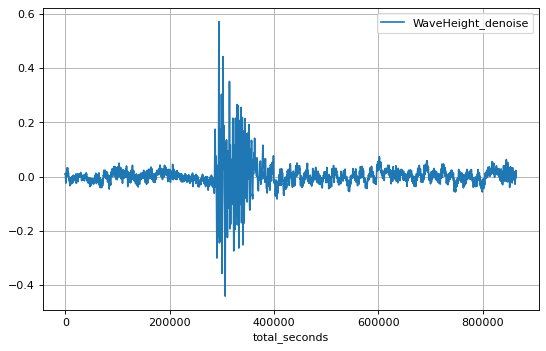

In [4]:
dummy_date = sandpt_2021['DateTime'] - sandpt_2021['DateTime'].iloc[0]
sandpt_2021['total_seconds'] = dummy_date.dt.total_seconds()
#total seconds see https://stackoverflow.com/questions/36156582/accessing-total-seconds-in-pandas-data-column
#drop slice see https://stackoverflow.com/questions/61363393/extracting-discontinuous-set-of-rows-in-pandas
sandpt_noises = sandpt_2021.drop(sandpt_2021.loc[4740:6670].index, inplace=False)
sandpt_noises.dropna(inplace=True)
timedata = sandpt_noises['total_seconds']
timedata_b = sandpt_noises['total_seconds'][:4740]
res1 = fit_sin(timedata, sandpt_noises['WaveHeight'])
res2 = fit_sin(timedata, sandpt_noises['WaveHeight']-res1["fitfunc"](timedata))
res3 = fit_sin(timedata_b,
               sandpt_noises['WaveHeight'][:4740]-\
               res2["fitfunc"](timedata_b)-res1["fitfunc"](timedata_b))
res4 = fit_sin(timedata,
               sandpt_noises['WaveHeight']-\
               res3["fitfunc"](timedata)-\
               res2["fitfunc"](timedata)-\
               res1["fitfunc"](timedata))
sandpt_2021['WaveHeight_denoise'] = sandpt_2021['WaveHeight'] -\
(res1["fitfunc"](sandpt_2021['total_seconds'])+\
res2["fitfunc"](sandpt_2021['total_seconds'])+\
res3["fitfunc"](sandpt_2021['total_seconds'])+\
res4["fitfunc"](sandpt_2021['total_seconds']))
fig = plt.figure(dpi=80, figsize=(8,5), facecolor='white')
ax1 = fig.add_subplot()
sandpt_2021.plot(x='total_seconds', y='WaveHeight_denoise', ax=ax1)
#ax1.plot(timedata, res1["fitfunc"](timedata)+res2["fitfunc"](timedata)+res3["fitfunc"](timedata),
#         "r-", label="y fit curve", linewidth=2)
ax1.grid()

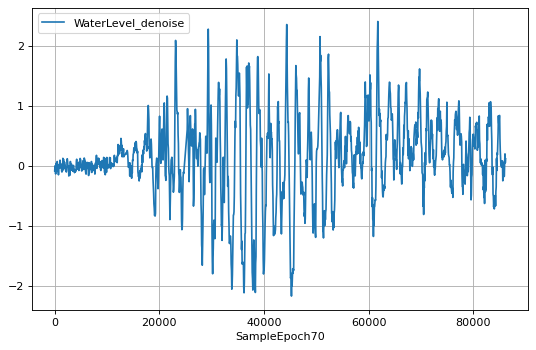

In [5]:
arica_2011['SampleEpoch70'] = arica_2011['SampleEpoch70']-arica_2011['SampleEpoch70'].loc[0]
arica_2011.loc[arica_2011['WaterLevel']<0.1, 'WaterLevel']=np.nan
arica_2011.dropna(inplace=True)
timedata = arica_2011['SampleEpoch70'].loc[:170]
res1 = fit_sin(timedata, arica_2011['WaterLevel'].loc[:170])
res2 = fit_sin(timedata, arica_2011['WaterLevel'].loc[:170]-res1["fitfunc"](timedata))
arica_2011['WaterLevel_denoise'] = arica_2011['WaterLevel'] -\
res1["fitfunc"](arica_2011['SampleEpoch70']) #-\
res2["fitfunc"](arica_2011['SampleEpoch70'])
fig = plt.figure(dpi=80, figsize=(8,5), facecolor='white')
ax2 = fig.add_subplot()
arica_2011.plot(x='SampleEpoch70', y='WaterLevel_denoise', ax=ax2)
ax2.grid()

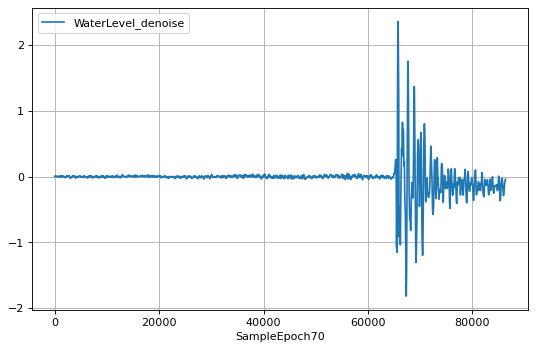

In [6]:
pagopago_2009['SampleEpoch70'] = pagopago_2009['SampleEpoch70']-pagopago_2009['SampleEpoch70'].loc[0]
timedata = pagopago_2009['SampleEpoch70'].loc[:1051]
res1 = fit_sin(timedata, pagopago_2009['WaterLevel'].loc[:1051])
res2 = fit_sin(timedata, pagopago_2009['WaterLevel'].loc[:1051]-res1["fitfunc"](timedata))
pagopago_2009['WaterLevel_denoise'] = pagopago_2009['WaterLevel'] -\
res1["fitfunc"](pagopago_2009['SampleEpoch70']) -\
res2["fitfunc"](pagopago_2009['SampleEpoch70'])
fig = plt.figure(dpi=80, figsize=(8,5), facecolor='white')
ax2 = fig.add_subplot()
pagopago_2009.plot(x='SampleEpoch70', y='WaterLevel_denoise', ax=ax2)
ax2.grid()

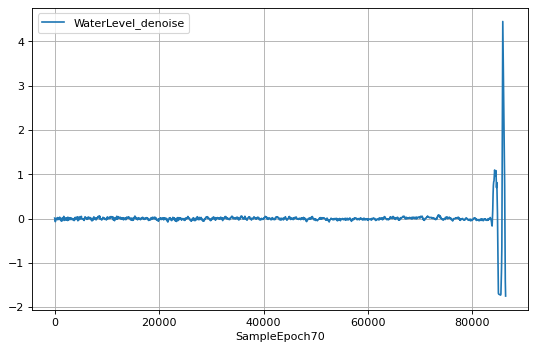

In [7]:
#Coquimbo denoise
coq_filt = coquimbo_2015['DateTime']>=datetime(2015, 9, 16, 23, 30, 0)
coquimbo_2015['SampleEpoch70'] = coquimbo_2015['SampleEpoch70']-coquimbo_2015['SampleEpoch70'].loc[0]
timedata = coquimbo_2015['SampleEpoch70'].loc[:1351]
res1 = fit_sin(timedata, coquimbo_2015['WaterLevel'].loc[:1351])
res2 = fit_sin(timedata, coquimbo_2015['WaterLevel'].loc[:1351]-res1["fitfunc"](timedata))
coquimbo_2015['WaterLevel_denoise'] = coquimbo_2015['WaterLevel'] -\
res1["fitfunc"](coquimbo_2015['SampleEpoch70']) -\
res2["fitfunc"](coquimbo_2015['SampleEpoch70'])
fig = plt.figure(dpi=80, figsize=(8,5), facecolor='white')
ax1 = fig.add_subplot()
coquimbo_2015.plot(x='SampleEpoch70', y='WaterLevel_denoise', ax=ax1)
#ax1.plot(timedata, res1["fitfunc"](timedata) + res2["fitfunc"](timedata),
#         "r-", label="y fit curve", linewidth=2)
ax1.grid()

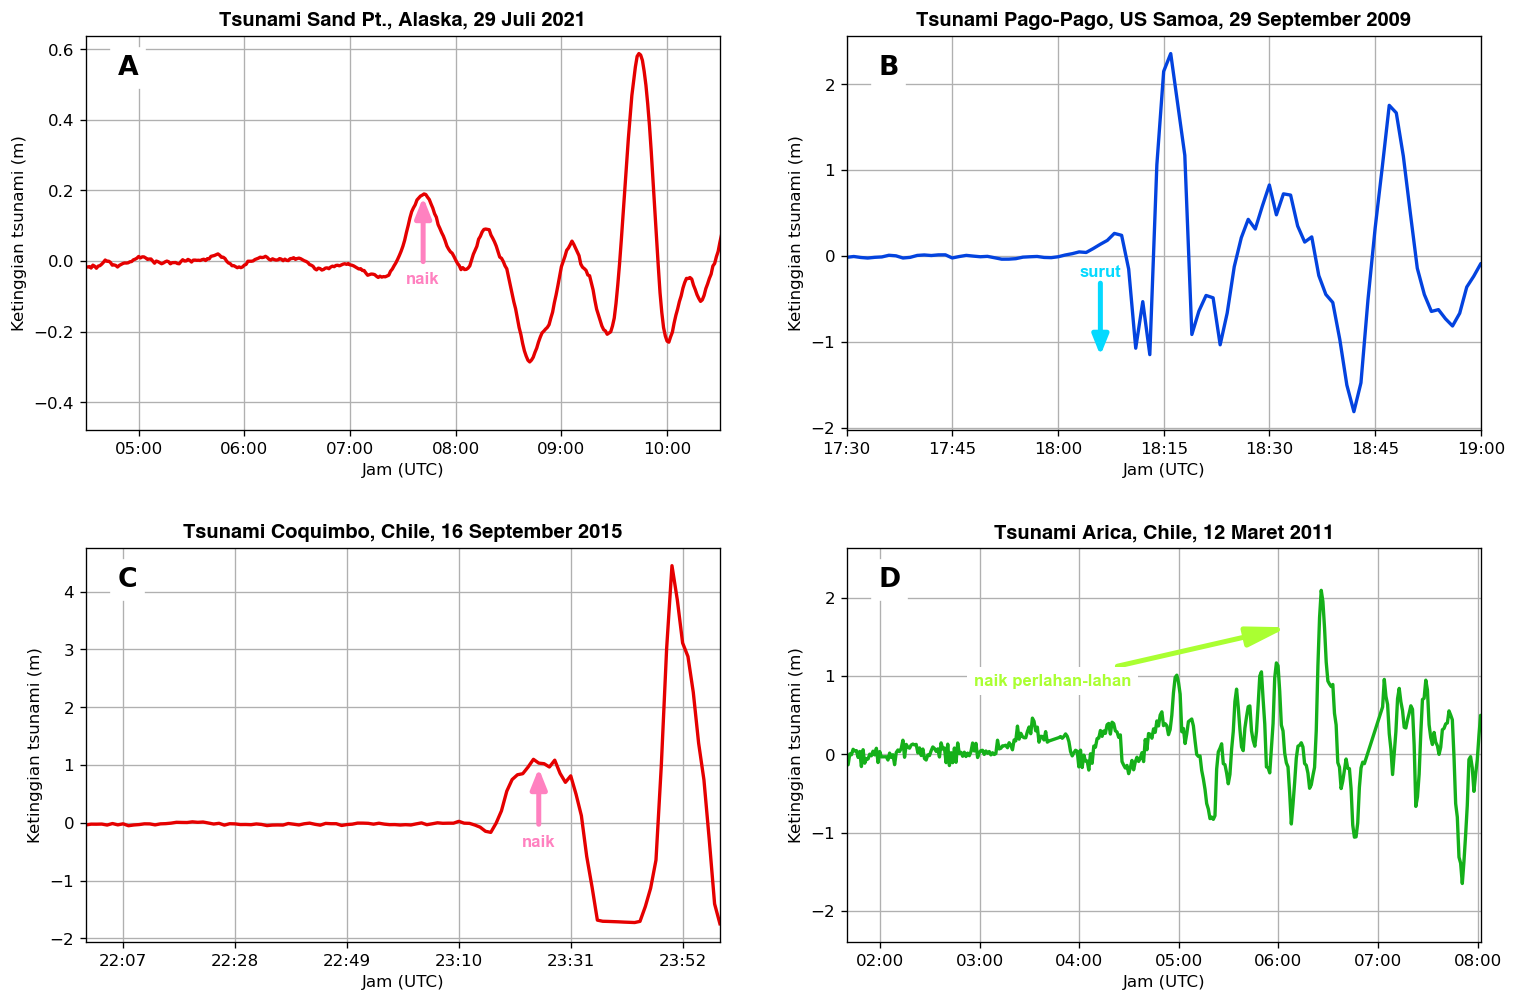

In [8]:
fig = plt.figure(dpi=120, figsize=(15,10), facecolor='white')
ax1 = fig.add_subplot(2,2,1)
dateFilter = (sandpt_2021['Month'] == '07') & (sandpt_2021['Day'] == '29')
sandpt_2021['WaveHeight_denoise'] = sandpt_2021['WaveHeight_denoise']+0.015
ax1.plot(sandpt_2021['DateTime'].loc[dateFilter],
         sandpt_2021['WaveHeight_denoise'].loc[dateFilter], color='xkcd:red', lw=2)
ax1.set_xlim([datetime(2021, 7, 29, 4, 30, 0), datetime(2021, 7, 29, 10, 30, 0)])
ax1.xaxis.set_major_locator(md.HourLocator(byhour=range(24), interval=1))
ax1.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax1.annotate('naik', xy=(datetime(2021, 7, 29, 7, 41, 30),0.19), xycoords='data',
             xytext=(datetime(2021, 7, 29, 7, 41, 30),-0.03),
             color='xkcd:pink', fontweight='bold', fontfamily='Arial',
             textcoords='data', ha='center', va='top',
             arrowprops=dict(arrowstyle="-|>, head_width=0.4, head_length=1", connectionstyle="arc3",
                             color='xkcd:pink',
                             lw=3),
             bbox=dict(fc='white', ec='none'))
ax1.grid(True)
ax1.set_xlabel('Jam (UTC)')
ax1.set_ylabel('Ketinggian tsunami (m)')
ax1.text(0.05,0.9,'A', fontweight='bold', transform=ax1.transAxes,
         fontsize=16, backgroundcolor='white')
ax1.set_title('Tsunami Sand Pt., Alaska, 29 Juli 2021', fontweight='bold', fontfamily='Helvetica')

ax2 = fig.add_subplot(2,2,2)
ax2.plot(pagopago_2009['DateTime'], pagopago_2009['WaterLevel_denoise'], color='xkcd:blue', lw=2)
ax2.set_xlim([datetime(2009, 9, 29, 17, 30, 0), datetime(2009, 9, 29, 19, 0, 0)])
ax2.xaxis.set_major_locator(md.MinuteLocator(byminute=[0,15,30,45]))
ax2.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax2.annotate('surut', xy=(datetime(2009, 9, 29, 18, 6, 0),-1.2), xycoords='data',
             xytext=(datetime(2009, 9, 29, 18, 6, 0),-0.1),
             color='xkcd:neon blue', fontweight='bold', fontfamily='Arial',
             textcoords='data', ha='center', va='top',
             arrowprops=dict(arrowstyle="-|>, head_width=0.4, head_length=1", connectionstyle="arc3",
                             color='xkcd:neon blue',
                             lw=3),
             bbox=dict(fc='white', ec='none', pad=0.2))
ax2.grid(True)
ax2.set_xlabel('Jam (UTC)')
ax2.set_ylabel('Ketinggian tsunami (m)')
ax2.text(0.05,0.9,'B', fontweight='bold', transform=ax2.transAxes,
         fontsize=16, backgroundcolor='white')
ax2.set_title('Tsunami Pago-Pago, US Samoa, 29 September 2009', fontweight='bold', fontfamily='Helvetica')

ax3 = fig.add_subplot(2,2,3)
ax3.plot(coquimbo_2015['DateTime'], coquimbo_2015['WaterLevel_denoise'], color='xkcd:red', lw=2)
ax3.set_xlim([datetime(2015, 9, 16, 22, 0, 0), datetime(2015, 9, 16, 23, 59, 0)])
ax3.xaxis.set_major_locator(md.MinuteLocator(byminute=range(60), interval = 21))
ax3.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax3.annotate('naik', xy=(datetime(2015, 9, 16, 23, 25, 0),1.0), xycoords='data',
             xytext=(datetime(2015, 9, 16, 23, 25, 0),-0.2),
             color='xkcd:pink', fontweight='bold', fontfamily='Arial',
             textcoords='data', ha='center', va='top',
             arrowprops=dict(arrowstyle="-|>, head_width=0.4, head_length=1", connectionstyle="arc3",
                             color='xkcd:pink',
                             lw=3),
             bbox=dict(fc='white', ec='none'))
ax3.grid(True)
ax3.set_xlabel('Jam (UTC)')
ax3.set_ylabel('Ketinggian tsunami (m)')
#plt.setp(ax3.xaxis.get_majorticklabels(), rotation = 90)
ax3.text(0.05,0.9,'C', fontweight='bold', transform=ax3.transAxes,
         fontsize=16, backgroundcolor='white')
ax3.set_title('Tsunami Coquimbo, Chile, 16 September 2015', fontweight='bold', fontfamily='Helvetica')

ax4 = fig.add_subplot(2,2,4)
ax4.plot(arica_2011['DateTime'], arica_2011['WaterLevel_denoise'], color='xkcd:green', lw=2)
ax4.set_xlim([datetime(2011, 3, 12, 1, 40, 0), datetime(2011, 3, 12, 8, 2, 0)])
ax4.xaxis.set_major_locator(md.HourLocator(interval = 1))
ax4.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
#annotate see https://stackoverflow.com/questions/36148773/how-to-change-the-head-size-of-the-double-head-annotate-in-matplotlib
ax4.annotate('naik perlahan-lahan', xy=(0.7,0.8), xycoords='axes fraction', xytext=(0.2,0.65),
             color='xkcd:lime', fontweight='bold', fontfamily='Arial', textcoords='axes fraction',
             arrowprops=dict(arrowstyle="-|>, head_width=0.5, head_length=2", connectionstyle="arc3",
                             color='xkcd:lime',
                             lw=3),
             bbox=dict(fc='white', ec='none'))
ax4.grid(True)
ax4.set_xlabel('Jam (UTC)')
ax4.set_ylabel('Ketinggian tsunami (m)')
#plt.setp(ax3.xaxis.get_majorticklabels(), rotation = 90)
ax4.text(0.05,0.9,'D', fontweight='bold', transform=ax4.transAxes,
         fontsize=16, backgroundcolor='white')
ax4.set_title('Tsunami Arica, Chile, 12 Maret 2011', fontweight='bold', fontfamily='Helvetica')

plt.subplots_adjust(hspace=0.3)